# Car auction price estimation

## Introduction

This notebook describes an estimation of car auction bid prices for auctions on the car dealer site KVD https://www.kvd.se/auktion/personbil

Auction data is extracted from the KVD site using the GitHub project at https://github.com/fredriksoderberg/auction-analysis/tree/master/auction_data  

### Data cleaning

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
#import numpy as np
#from sklearn.metrics import mean_squared_error
%matplotlib inline

In [10]:
data = pd.read_csv('kvd_auction_20160404.csv', index_col = 0)

Extract data subset (highest bid, estimated action price) 

In [11]:
datasubset = data[['highest_bid', 'estimated_auction_price']]

Remove non digits from price data.

In [12]:
datasubset = datasubset.replace(to_replace=r'[a-z.]|[A-Z]| ', value=r'', regex=True)

Remove rows with empty data.

In [13]:
datasubset.dropna()
datasubset = datasubset[datasubset.estimated_auction_price != '']

Extraction of estimated auction price ranges.

In [14]:
datasubset['est_auction_price_low'] = datasubset['estimated_auction_price'].str.split('-').str[0]
datasubset['est_auction_price_high'] = datasubset['estimated_auction_price'].str.split('-').str[1]

Cast to integer datatype 

In [15]:
datasubset['highest_bid'] = datasubset['highest_bid'].astype(int)
datasubset['est_auction_price_low'] = datasubset['est_auction_price_low'].astype(int)
datasubset['est_auction_price_high'] = datasubset['est_auction_price_high'].astype(int)

### Accuracy of estimated auction prices

Calculate average estimated auction prices

In [16]:
datasubset['avg_est_auction_price'] = datasubset[['est_auction_price_low', 'est_auction_price_high']].mean(axis=1)

Calculate average deviation from (avg) estimated auction price. Get the mean over all auctions.

In [17]:
datasubset['est_auction_price_error'] = \
datasubset['highest_bid'].sub(datasubset['avg_est_auction_price'], axis=0).div(datasubset['avg_est_auction_price'], axis=0).abs()
datasubset['est_auction_price_error'].mean()

0.08683623661995511

Plot

(0, 500000)

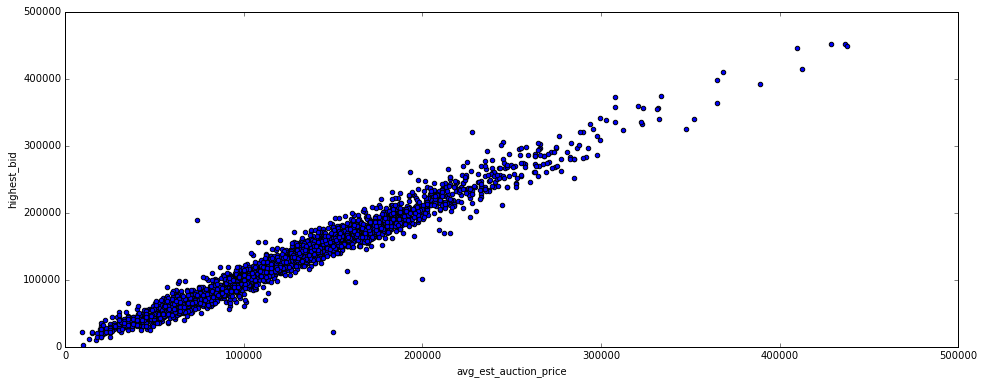

In [36]:
ax = datasubset.plot(kind='scatter', x='avg_est_auction_price', y='highest_bid', figsize=(16,6))
ax.set_xlim(0, 500000)
ax.set_ylim(0, 500000)

Calculate percentage of auction prices within the estimated range

In [33]:
nr_within_range = len(datasubset[(datasubset['highest_bid'] > datasubset['est_auction_price_low']) &  \
                             (datasubset['highest_bid'] < datasubset['est_auction_price_high'])])
total_nr_of_auctions = len(datasubset)
nr_within_range / total_nr_of_auctions

0.7438898450946644

### Data visualization

Top 10 auction winners

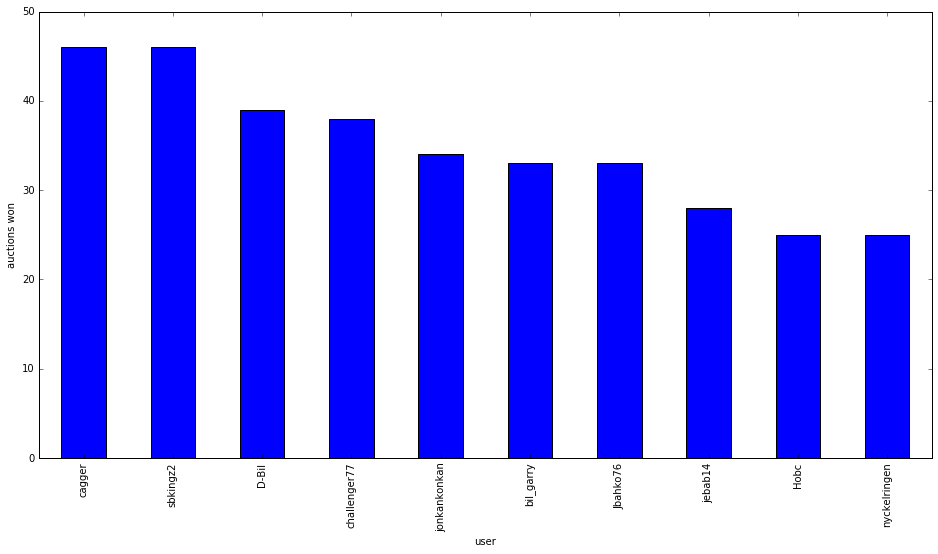

In [38]:
datasubset['bidder'] = data['bidder']
nr_of_bids_by_bidder = datasubset['bidder'].groupby(datasubset['bidder']).size() 
nr_of_bids_by_bidder = nr_of_bids_by_bidder[nr_of_bids_by_bidder.ix[:,] > 5] 
nr_of_bids_by_bidder.sort_values(ascending=False, inplace=True)
nr_of_bids_by_bidder = nr_of_bids_by_bidder.head(10)
ax = nr_of_bids_by_bidder.plot(kind='bar', figsize=(16,8))
ax.set_ylabel('auctions won')
ax.set_xlabel('user')

Auctions by place of sale

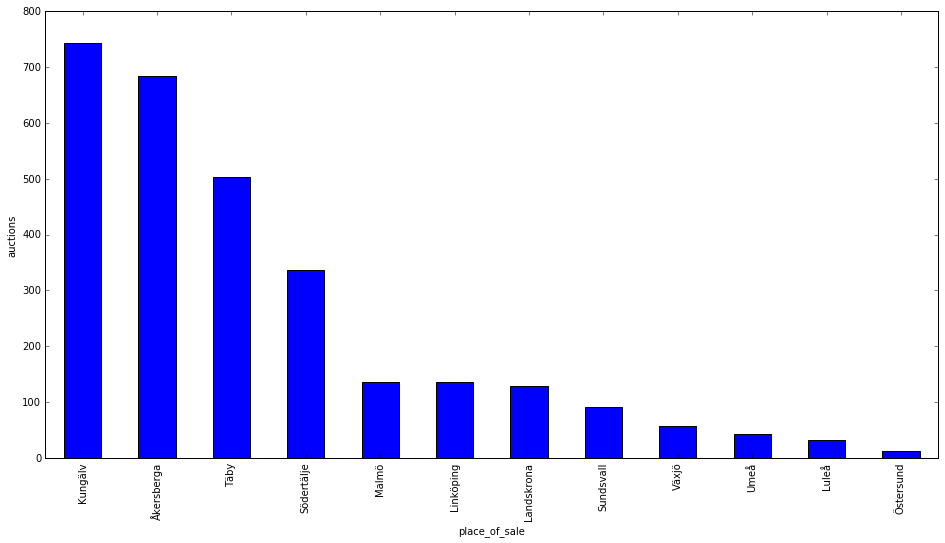

In [48]:
datasubset['place_of_sale'] = data['place_of_sale']
auctions_by_place_of_sale = datasubset['place_of_sale'].groupby(datasubset['place_of_sale']).size()
auctions_by_place_of_sale.sort_values(ascending = False, inplace=True)
ax = auctions_by_place_of_sale.plot(kind='bar', figsize=(16,8))
ax.set_ylabel('auctions')

Auctions by weekday

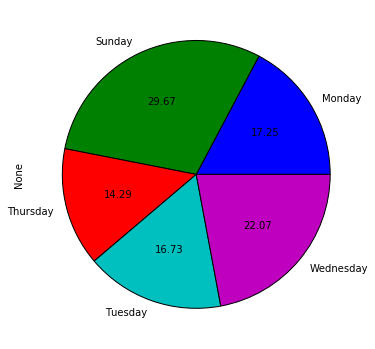

In [73]:
datasubset['auction_date'] = pd.to_datetime(data['auction_date'], errors='coerce')
datasubset['auction_weekday'] = datasubset['auction_date'].dt.dayofweek
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
datasubset['auction_weekday'].replace(days, inplace=True)
auction_date_weekday = datasubset['auction_weekday'].groupby(datasubset['auction_weekday']).size()
auction_date_weekday.plot.pie(figsize=(6,6), autopct='%.2f')